In [2]:
import torch.nn as nn
import torch
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
nn.Sequential(nn.Linear(128, 128)) + nn.Sequential(nn.Linear(128, 128))

Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
)

In [5]:
nn.Linear(129, 129) + nn.Sequential(nn.Linear(128, 128))

TypeError: unsupported operand type(s) for +: 'Linear' and 'Sequential'

In [ ]:
a = torch.arange(129 * 3).reshape(3, 129)
a.shape


device = 'cuda'

In [ ]:

import nerf_model

model = nerf_model.NerfModel(input_size_direction=3, input_size_ray=3).to(device)

batch_size = 5
n_rays = 20 * 20
n_samples = 20


# for each image in the batch we going to geneate 256 * 256 directions and rays


directions = torch.arange(batch_size * n_rays * n_samples * 3, dtype=torch.float32) \
                   .reshape(batch_size, n_rays, n_samples, 3).to(device)
rays = torch.arange(batch_size * n_rays * n_samples * 3, dtype=torch.float32) \
                   .reshape(batch_size, n_rays, n_samples, 3).to(device)



directions.shape
# batch_size n_rays, 4
model(rays, directions).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 28.06 MiB is free. Including non-PyTorch memory, this process has 3.78 GiB memory in use. Of the allocated memory 3.70 GiB is allocated by PyTorch, and 13.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import pycolmap

scene_manager = pycolmap.SceneManager("/home/kolek/Edu/project/test_data/sparse/0")

In [ ]:
scene_manager.load_cameras()
scene_manager.load_images()
len(scene_manager.cameras), len(scene_manager.images)

(1, 2)

In [ ]:
camera = scene_manager.cameras[1]
print(camera)

OPENCV 960 1280 1083.3341134167667 1075.6291880913084 480.0 640.0 -0.021853695520177647 -0.022266433852242817 0.002635423093899853 -0.00126717372198474


In [ ]:
import numpy as np
import torch

image = scene_manager.images[1]

focal_length_x = camera.fx
focal_length_y = camera.fy
principal_point_x = camera.cx
principal_point_y = camera.cy

# both camtopix and pixtocam are 3,3 matrix

camtopix = np.array([[focal_length_x, 0, principal_point_x],
                     [0, focal_length_y, principal_point_y],
                     [0, 0, 1]])
pixtocam = np.linalg.inv(camtopix)


# extract world2cam matrix from image

translation = torch.from_numpy(image.C()).reshape(3, 1)
rotation = torch.from_numpy(image.R())
bottom = torch.tensor([0, 0, 0, 1], dtype=torch.float32).reshape(1, 4)
world2cam = np.concatenate([np.concatenate([rotation, translation], axis=1), bottom], axis=0)
cam2world = np.linalg.inv(world2cam)

pose = cam2world[:3, :4]
#pose = cam2world
#pose @ np.diag([1, -1, -1, 1])

pose

array([[ 1.        ,  0.        ,  0.        , -4.60117957],
       [ 0.        ,  1.        ,  0.        , -1.00413135],
       [ 0.        ,  0.        ,  1.        ,  1.67954364]])

In [ ]:
for img_index, img in scene_manager.images.items():
    print(img)

In [ ]:
type(scene_manager.images)

collections.OrderedDict

In [ ]:
from PIL import Image

img = Image.open(scene_manager.image_path + image.name)
img = img.resize([800, 800], Image.Resampling.LANCZOS)
img.mode
img.width

800

In [ ]:
from torchvision import transforms

tr =  transforms.ToTensor()
img = tr(img)
img.shape

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
img.shape

torch.Size([3, 800, 800])

In [ ]:
import sys
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')
from dataset import NerfDatasetRealImages

nerf_dataset = NerfDatasetRealImages(data_path="/home/kolek/Edu/project/test_data/sparse/0/", image_width=200, image_height=200)

/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
from torchvision import transforms

to_pil_image = transforms.ToPILImage()
for elem in nerf_dataset:
    img = to_pil_image(elem['rgb'])
    print(elem['rgb'].shape)
    img.show()
    break

torch.Size([3, 200, 200])


In [ ]:
import torch
H = 5
W = 5
i, j = torch.meshgrid(torch.linspace(0, W - 1, W), torch.linspace(0, H - 1, H), indexing="ij")
print(i.shape, j.shape)

torch.Size([5, 5]) torch.Size([5, 5])


In [ ]:
torch.stack([i, j, torch.ones_like(i)], dim=-1).shape

torch.Size([5, 5, 3])

In [ ]:
import sys
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')
import ray_sampler

raysampler = ray_sampler.RaySampler(5)

ray_samples = raysampler(ray_count=1, near=2., far=6.)

print(ray_samples)

tensor([[2.1145, 2.6435, 3.3480, 4.6654, 5.3041]])


In [ ]:
# artificial test of ray sampler nerf_model and volume renderer
import sys
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')
from dataset import NerfDatasetRealImages
import ray_sampler
import volume_renderer
import nerf_model
image_width = image_height = 200
nerf_dataset = NerfDatasetRealImages(data_path="/home/kolek/Edu/project/test_data/sparse/0/", image_width=image_width, image_height=image_height)

n_samples = 5

raysampler = ray_sampler.RaySampler(n_samples)

model = nerf_model.NerfModel(input_size_ray=3, input_size_direction=3)

volumerender = volume_renderer.VolumeRenderer()


# take image from dataset
img_data = nerf_dataset[0]
# sample ray depth values
ray_count = image_height * image_height
depth_values = raysampler(ray_count, near=img_data['near'], far=img_data['far'])

print(depth_values.shape)
# use depth samples to scale the rays
rays_origin = img_data['ray_origins']
rays_directions = img_data['ray_directions']

ray_points = rays_origin[..., None, :] + rays_directions[..., None, :] * depth_values[..., :, None]
print(ray_points.shape)

expanded_ray_directions = rays_directions[..., None, :].expand_as(ray_points)
#print(expanded_ray_directions[0,:])
#print(expanded_ray_directions.shape, rays_directions.shape)
# feed rays to the model and expanded directions to the model
radiance_field = model(ray_points, expanded_ray_directions)
print(radiance_field.shape)


torch.Size([40000, 5])
torch.Size([40000, 5, 3])
torch.Size([40000, 5, 4])


In [ ]:
rgb = volumerender(radiance_field, rays_directions, depth_values)

In [ ]:
rgb.reshape(image_width, image_height, 3).shape

torch.Size([200, 200, 3])

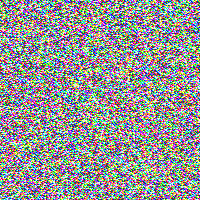

In [ ]:
to_pil_image(rgb.reshape(3, image_width, image_height))

In [ ]:
import torch
p = torch.Tensor([1, 2, 3, 4, 5])
torch.cumprod(p, dim=0)[:-1]

tensor([ 1.,  2.,  6., 24.])

In [1]:
import sys
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')
from dataset import NerfDatasetRealImages

nerf_dataset = NerfDatasetRealImages(data_path="/home/kolek/Edu/project/coffee_nerf/sparse/0/", image_width=50, image_height=50)

/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


480.0 640.0


photo_10_2024-06-02_18-25-33.jpg
torch.Size([2500, 3])
photo_11_2024-06-02_18-25-33.jpg
torch.Size([2500, 3])


Text(0.5, 0, 'x')

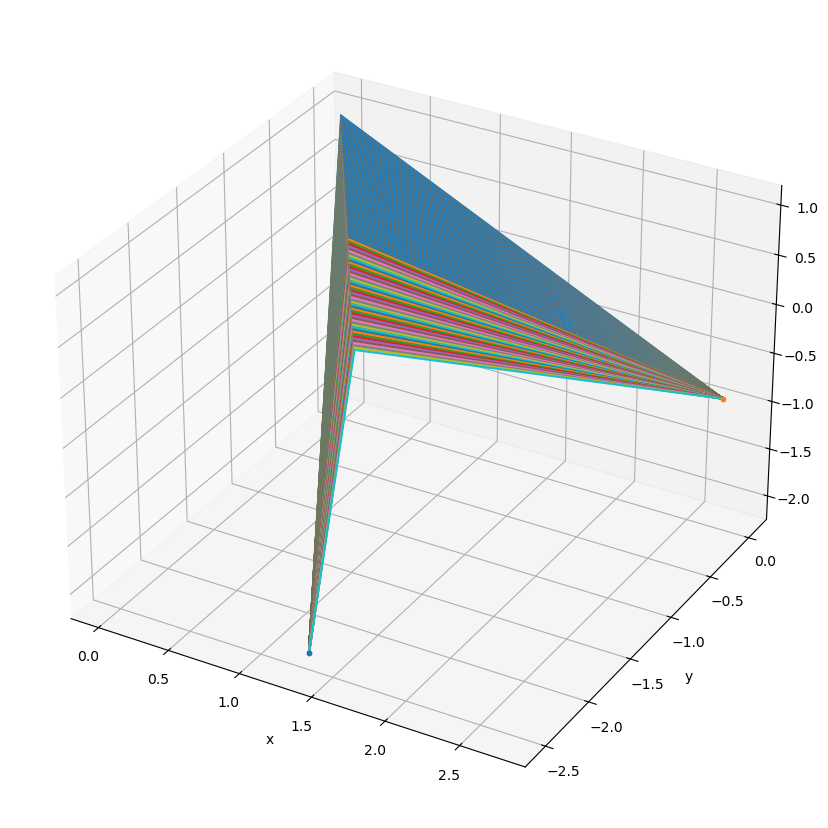

In [3]:
from torchvision import transforms
import matplotlib.pyplot as plt


fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
counter = 0

to_pil_image = transforms.ToPILImage()
for elem in nerf_dataset:
    if counter == 2:
        break
    print(elem['image_name'])
    ray_directions = elem['ray_directions']
    ray_origins = elem['ray_origins']
    # sample one ray_direction and one ray_origin
    print(ray_origins.shape)
    o_x, o_y, o_z = ray_origins[0]
    ax.scatter(o_x, o_y, o_z, label="origin", s=10)

    for ray_dir in ray_directions:
        d_x, d_y, d_z = ray_dir
        ax.plot([o_x, d_x], [o_y, d_y], [o_z, d_z])
    counter += 1
    #ax.scatter(d_x, d_y, d_z, label="direction", s=10)

    #ax.plot(o_x, o_y, o_z, label="direction", markersize=14)
plt.ylabel("y")
plt.xlabel("x")

In [ ]:
import sys
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')
import nerf_system

config = {
    'input_size_ray': 3,
    'input_size_direction': 3,
    'n_ray_samples': 12,
    'image_width': 150,
    'image_height': 150,
    'batch_size': 150 * 150,
    #'dataset_type': 'real',
    #'train_dataloader_path': '/home/kolek/Edu/project/coffee_nerf/',
    "dataset_type": "blender",
    "train_dataset_path": "/home/kolek/Edu/project/nerf_synthetic/lego",
}

nerfsys = nerf_system.NerfSystem(**config)

/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
import lightning as L
epochs = 5
trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    enable_model_summary=True,
    enable_progress_bar=True,
    #num_sanity_val_steps=1,
    #check_val_every_n_epoch=1,
    benchmark=False,
    profiler=None,
    log_every_n_steps=24
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params
---------------------------------------------------
0 | model           | NerfModel      | 496 K 
1 | ray_sampler     | RaySampler     | 0     
2 | volume_renderer | VolumeRenderer | 0     
3 | loss            | MSELoss        | 0     
---------------------------------------------------
496 K     Trainable params
0         Non-trainable params
496 K     Total params
1.985     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


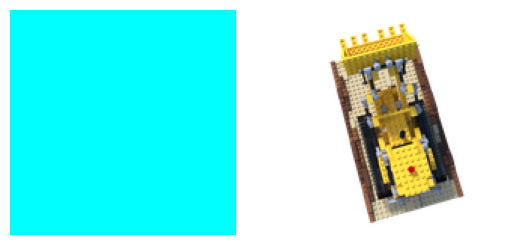

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


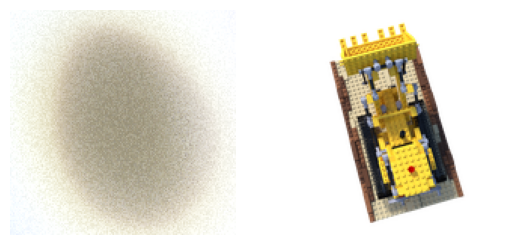

/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.fit(nerfsys)

In [ ]:
from torchvision import transforms
import torch
to_pil_image = transforms.ToPILImage()
# validation
img_data = nerfsys.train_dataset[0]
#to_pil_image(rgb.reshape(3, image_width, image_height))
with torch.no_grad():
    rgb = nerfsys(img_data['ray_origins'][None,...], img_data['ray_directions'][None,...], img_data['near'], img_data['far'])
    rgb = rgb.reshape(3, 150, 150)
    img = to_pil_image(rgb)
    img.show()

In [ ]:
import sys
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')
import dataset


blender = dataset.BlenderDataset(root_dir="/home/kolek/Edu/project/nerf_synthetic/lego", split='train', img_wh=(150, 150))

In [ ]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset=blender, batch_size=150 * 150, shuffle=True, pin_memory=True)

In [ ]:
for batch in train_dataloader:
    print(batch['rays'].shape)
    break

torch.Size([22500, 8])


In [ ]:
import torch


t1 = torch.arange(5* 3 * 2).reshape(5, 3, 2)




tensor([[ 0,  2,  4],
        [ 6,  8, 10],
        [12, 14, 16],
        [18, 20, 22],
        [24, 26, 28]])

In [1]:
# training on real data
import sys
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/')
sys.path.insert(1, '/home/kolek/Edu/project/video-to-3d/src/pycolmap')
import nerf_system

config = {
    'input_size_ray': 3,
    'input_size_direction': 3,
    'n_ray_samples': 12,
    'image_width': 150,
    'image_height': 150,
    'batch_size': 1,
    'dataset_type': 'real',
    'train_dataset_path': '/home/kolek/Edu/project/nerf_crocs/',
    #"dataset_type": "blender",
    #"train_dataset_path": "/home/kolek/Edu/project/nerf_synthetic/lego",
}

nerfsys = nerf_system.NerfSystem(**config)

/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import lightning as L
epochs = 100
trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    enable_model_summary=True,
    enable_progress_bar=True,
    #num_sanity_val_steps=1,
    #check_val_every_n_epoch=1,
    benchmark=False,
    profiler=None,
    log_every_n_steps=24
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


360.0 640.0
360.0 640.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params
---------------------------------------------------
0 | model           | NerfModel      | 496 K 
1 | ray_sampler     | RaySampler     | 0     
2 | volume_renderer | VolumeRenderer | 0     
3 | loss            | MSELoss        | 0     
---------------------------------------------------
496 K     Trainable params
0         Non-trainable params
496 K     Total params
1.985     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


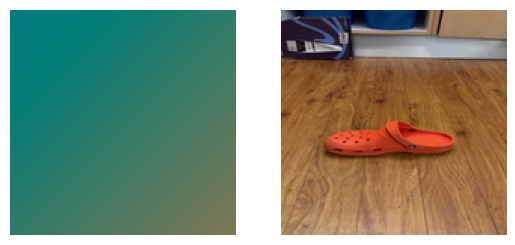

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

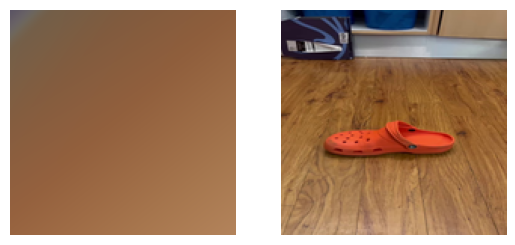

/home/kolek/miniconda3/envs/usual/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [3]:
trainer.fit(nerfsys)

In [ ]:
import cv2
import os
assert os.path.exists("/home/kolek/Edu/project/IMG_1974.MOV")

vidcap = cv2.VideoCapture("/home/kolek/Edu/project/IMG_1974.MOV")
success, image = vidcap.read()

#os.mkdir(f"{self.train_path}/images")
#os.mkdir(f"{self.val_path}/images")
#os.mkdir(f"{self.image_dump_path}/images")
count = 0
while success:
    cv2.imwrite(f"/home/kolek/Edu/project/nerf_crocs/images/frame{count}.jpg", image)     # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1
print(f"total images {count}")

total images 507
